## Imports

In [ ]:
import os
import inspect
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from IPython.display import Audio, display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import preprocessed dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/NLP_DS/tts_dataset.csv')

In [ ]:
df.head()

,Unnamed: 0,Unique_ID,Audio_Path,Transcript_Path,transcript,phonemes,phoneme_ids,mel_spec_path
0,0,5945,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,chakula chetu a book on indigenous recipes fro...,CH AA K UH L AA CH EH T UH AA B OO K O...,"[3, 0, 15, 37, 17, 0, 3, 7, 34, 37, 0, 2, 27, ...",/content/drive/MyDrive/NLP_DS/mel_spec/tweet_5...
1,1,598,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,polisi amuua mpenziwe afisa wa polisi amuua mp...,P OH L IH S IH AA M UU AA M P EH NZ IH W E...,"[29, 28, 17, 13, 31, 13, 0, 18, 36, 0, 18, 29,...",/content/drive/MyDrive/NLP_DS/mel_spec/tweet_5...
2,2,161,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,jamaa ni mtafutaji halisi weeeeeee kumbe dolph...,JH AA M AA AA N IH M T AA F UH T AA JH IH ...,"[14, 0, 18, 0, 0, 20, 13, 18, 34, 0, 8, 37, 34...",/content/drive/MyDrive/NLP_DS/mel_spec/tweet_1...
3,3,3210,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,vodka na bei yake imekubali ama aje wadau s,V OH D K AA N AA B EH IH Y AA K EH IH ...,"[38, 28, 4, 15, 0, 20, 0, 2, 7, 13, 40, 0, 15,...",/content/drive/MyDrive/NLP_DS/mel_spec/tweet 3...
4,4,982,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,mauti ya familia mama na wanawe watatu wafarik...,M AA UH T IH Y AA F AA M IH L IH AA M AA...,"[18, 0, 37, 34, 13, 40, 0, 8, 0, 18, 13, 17, 1...",/content/drive/MyDrive/NLP_DS/mel_spec/tweet_9...


In [ ]:
# df['mel_spec_path'] = df['mel_spec_path'].str.replace(
#     '/content/drive/MyDrive/NLP_DS/',
#     '/kaggle/input/mel-spec/'
# )

In [ ]:
file_path = "/content/drive/MyDrive/NLP_DS/mel_spec/tweet 2656_mel.npy"
mel_spec = np.load(file_path)
print("Mel spectrogram shape:", mel_spec.shape)

Mel spectrogram shape: (80, 1164)


In [ ]:
df=df.drop(columns=['Unnamed: 0'])
df.head()

,Unique_ID,Audio_Path,Transcript_Path,transcript,phonemes,phoneme_ids,mel_spec_path
0,5945,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,chakula chetu a book on indigenous recipes fro...,CH AA K UH L AA CH EH T UH AA B OO K O...,"[3, 0, 15, 37, 17, 0, 3, 7, 34, 37, 0, 2, 27, ...",/kaggle/input/mel-spec/mel_spec/tweet_5945_mel...
1,598,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,polisi amuua mpenziwe afisa wa polisi amuua mp...,P OH L IH S IH AA M UU AA M P EH NZ IH W E...,"[29, 28, 17, 13, 31, 13, 0, 18, 36, 0, 18, 29,...",/kaggle/input/mel-spec/mel_spec/tweet_598_mel.npy
2,161,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,jamaa ni mtafutaji halisi weeeeeee kumbe dolph...,JH AA M AA AA N IH M T AA F UH T AA JH IH ...,"[14, 0, 18, 0, 0, 20, 13, 18, 34, 0, 8, 37, 34...",/kaggle/input/mel-spec/mel_spec/tweet_161_mel.npy
3,3210,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,vodka na bei yake imekubali ama aje wadau s,V OH D K AA N AA B EH IH Y AA K EH IH ...,"[38, 28, 4, 15, 0, 20, 0, 2, 7, 13, 40, 0, 15,...",/kaggle/input/mel-spec/mel_spec/tweet 3210_mel...
4,982,/content/drive/MyDrive/NLP_DS/final_audio/twee...,/content/drive/MyDrive/NLP_DS/tweet_transcript...,mauti ya familia mama na wanawe watatu wafarik...,M AA UH T IH Y AA F AA M IH L IH AA M AA...,"[18, 0, 37, 34, 13, 40, 0, 8, 0, 18, 13, 17, 1...",/kaggle/input/mel-spec/mel_spec/tweet_982_mel.npy


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Full dataset size:", len(df))

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print("Train size:", len(train_df), "Test size:", len(test_df))

Using device: cuda
Full dataset size: 4538
Train size: 3630 Test size: 908


# Embedding and batching

In [ ]:
class TacotronDataset(Dataset):
    def __init__(self, df, phoneme_col, mel_spec_path_col, max_phoneme_length=100, max_mel_length=1200):
        self.df = df
        self.phoneme_col = phoneme_col
        self.mel_spec_path_col = mel_spec_path_col
        self.max_phoneme_length = max_phoneme_length
        self.max_mel_length = max_mel_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Get phoneme_ids (convert if stored as string)
        phoneme_ids = row[self.phoneme_col]
        if isinstance(phoneme_ids, str):
            phoneme_ids = ast.literal_eval(phoneme_ids)
        phoneme_ids = phoneme_ids[:self.max_phoneme_length] + [0] * max(0, self.max_phoneme_length - len(phoneme_ids))
        phoneme_ids_tensor = torch.tensor(phoneme_ids, dtype=torch.long)

        # Load and normalize mel spectrogram
        mel_spec = np.load(row[self.mel_spec_path_col])
        mel_spec = (mel_spec - np.mean(mel_spec)) / (np.std(mel_spec) + 1e-6)  # Normalize
        mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float).transpose(0, 1)
        mel_spec_tensor = F.pad(mel_spec_tensor, (0, 0, 0, max(0, self.max_mel_length - mel_spec_tensor.shape[0])))[:self.max_mel_length, :]

        return phoneme_ids_tensor, mel_spec_tensor

def collate_fn(batch):
    phoneme_batch = torch.stack([item[0] for item in batch], dim=0)
    mel_batch = torch.stack([item[1] for item in batch], dim=0)
    return phoneme_batch, mel_batch

## Creating dataloaders

In [ ]:
train_dataset = TacotronDataset(train_df, phoneme_col="phoneme_ids", mel_spec_path_col="mel_spec_path")
test_dataset = TacotronDataset(test_df, phoneme_col="phoneme_ids", mel_spec_path_col="mel_spec_path")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=0)

# Tacotron 2

## Encoder

In [ ]:
vocab_size = 50
embedding_dim = 256
encoder_dim = 512
decoder_dim = 512
mel_dim = 80

class SimpleEncoder(nn.Module):
    def __init__(self, embedding_dim, encoder_dim=512):
        super(SimpleEncoder, self).__init__()
        self.conv = nn.Conv1d(embedding_dim, encoder_dim, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(encoder_dim, encoder_dim // 2, batch_first=True, bidirectional=True, num_layers=2)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.conv(x))
        x = x.transpose(1, 2)
        outputs, _ = self.lstm(x)
        return outputs

## Attention Mechanism

In [ ]:
class SimpleAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim=128):
        super(SimpleAttention, self).__init__()
        self.W1 = nn.Linear(encoder_dim, attention_dim)
        self.W2 = nn.Linear(decoder_dim, attention_dim)
        self.V = nn.Linear(attention_dim, 1)

    def forward(self, encoder_outputs, decoder_hidden):
        dec_hidden_expanded = decoder_hidden.unsqueeze(1).expand_as(encoder_outputs)
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(dec_hidden_expanded))).squeeze(-1)
        weights = F.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, weights

## Decoder

In [ ]:
class SimpleDecoder(nn.Module):
    def __init__(self, encoder_dim, decoder_dim=512, mel_dim=80):
        super(SimpleDecoder, self).__init__()
        self.decoder_dim = decoder_dim
        self.lstm_cell = nn.LSTMCell(mel_dim + encoder_dim, decoder_dim)
        self.attention = SimpleAttention(encoder_dim, decoder_dim, attention_dim=128)
        self.hidden_linear = nn.Linear(encoder_dim, decoder_dim)
        self.cell_linear = nn.Linear(encoder_dim, decoder_dim)
        self.linear = nn.Linear(decoder_dim + encoder_dim, mel_dim)

        # Trainable hidden state initialization
        self.init_hidden = nn.Parameter(torch.zeros(decoder_dim))
        self.init_cell = nn.Parameter(torch.zeros(decoder_dim))

    def forward(self, encoder_outputs, mel_targets, teacher_forcing_ratio=1.0):
        B, T_mel, mel_dim = mel_targets.size()
        device = encoder_outputs.device

        # Initialize trainable hidden and cell states
        decoder_hidden = self.init_hidden.expand(B, -1).to(device)
        decoder_cell = self.init_cell.expand(B, -1).to(device)

        decoder_input = torch.zeros(B, mel_dim).to(device)
        outputs = []

        for t in range(T_mel):
            context, _ = self.attention(encoder_outputs, decoder_hidden)
            input_combined = torch.cat([decoder_input, context], dim=1)
            decoder_hidden, decoder_cell = self.lstm_cell(input_combined, (decoder_hidden, decoder_cell))
            context, _ = self.attention(encoder_outputs, decoder_hidden)
            out = self.linear(torch.cat([decoder_hidden, context], dim=1))
            outputs.append(out.unsqueeze(1))
            decoder_input = mel_targets[:, t, :] if torch.rand(1).item() < teacher_forcing_ratio else out

        return torch.cat(outputs, dim=1)

class PostNet(nn.Module):
    def __init__(self, mel_dim):
        super(PostNet, self).__init__()
        self.conv1 = nn.Conv1d(mel_dim, 512, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(512, 512, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(512, mel_dim, kernel_size=5, padding=2)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x.transpose(1, 2)



## Model

In [ ]:
class SimpleTacotron2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, encoder_dim, decoder_dim, mel_dim):
        super(SimpleTacotron2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder = SimpleEncoder(embedding_dim, encoder_dim)
        self.decoder = SimpleDecoder(encoder_dim, decoder_dim, mel_dim)
        self.postnet = PostNet(mel_dim)

    def forward(self, phoneme_ids, mel_targets, teacher_forcing_ratio):
        embedded = self.embedding(phoneme_ids)
        encoder_outputs = self.encoder(embedded)
        mel_outputs = self.decoder(encoder_outputs, mel_targets, teacher_forcing_ratio)
        refined_mel_outputs = self.postnet(mel_outputs)
        return refined_mel_outputs

# Training model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
vocab_size = 50
embedding_dim = 256
encoder_dim = 256
decoder_dim = 256
mel_dim = 80
num_epochs = 100 # Use high epoch
learning_rate = 0.0005

## Initialize model and create checkpoints

### Training model

Using device: cuda


<ipython-input-17-6e324b60dab6>:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed Precision scaler
<ipython-input-17-6e324b60dab6>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/20], Train Loss: 0.0954, Teacher Forcing Ratio: 1.00


<ipython-input-17-6e324b60dab6>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/20], Test Loss: 0.8892
Epoch [2/20], Train Loss: 0.0311, Teacher Forcing Ratio: 0.99
Epoch [2/20], Test Loss: 0.8937
Epoch [3/20], Train Loss: 0.0202, Teacher Forcing Ratio: 0.98
Epoch [3/20], Test Loss: 0.8844
Epoch [4/20], Train Loss: 0.0154, Teacher Forcing Ratio: 0.97
Epoch [4/20], Test Loss: 0.8787
Epoch [5/20], Train Loss: 0.0125, Teacher Forcing Ratio: 0.96
Epoch [5/20], Test Loss: 0.8983
Checkpoint saved: ./checkpoints/tacotron2_epoch05.pth
Epoch [6/20], Train Loss: 0.0107, Teacher Forcing Ratio: 0.95
Epoch [6/20], Test Loss: 0.8970
Epoch [7/20], Train Loss: 0.0096, Teacher Forcing Ratio: 0.94
Epoch [7/20], Test Loss: 0.8990
Epoch [8/20], Train Loss: 0.0088, Teacher Forcing Ratio: 0.93
Epoch [8/20], Test Loss: 0.8994
Epoch [9/20], Train Loss: 0.0082, Teacher Forcing Ratio: 0.92
Epoch [9/20], Test Loss: 0.8900
Epoch [10/20], Train Loss: 0.0074, Teacher Forcing Ratio: 0.91
Epoch [10/20], Test Loss: 0.8939
Checkpoint saved: ./checkpoints/tacotron2_epoch10.pth
Epoch [11/20

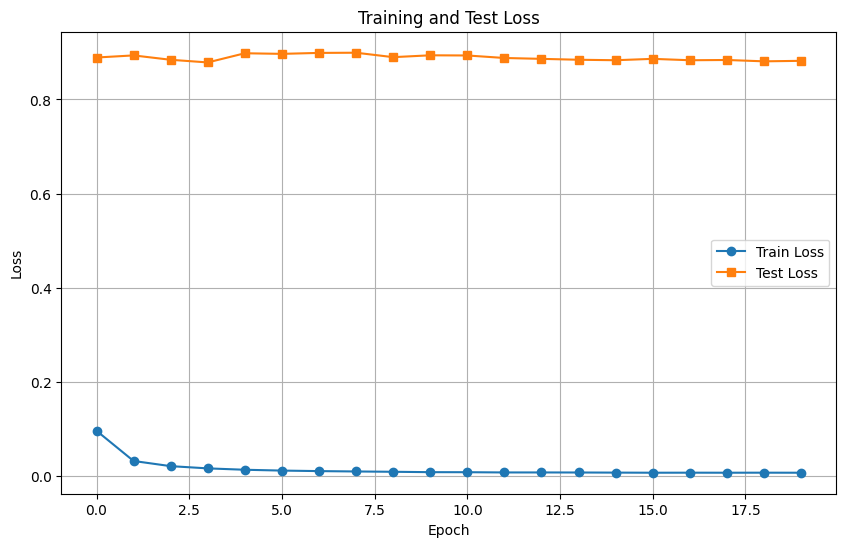

In [ ]:
model = SimpleTacotron2(vocab_size, embedding_dim, encoder_dim, decoder_dim, mel_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scaler = GradScaler()

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    teacher_forcing_ratio = max(0.5, 1.0 - epoch * 0.01)
    model.train()
    running_loss = 0.0

    for phoneme_ids, mel_targets in train_loader:
        phoneme_ids = phoneme_ids.to(device)
        mel_targets = mel_targets.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(phoneme_ids, mel_targets, teacher_forcing_ratio)
            loss = criterion(outputs, mel_targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * phoneme_ids.size(0)

    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Teacher Forcing Ratio: {teacher_forcing_ratio:.2f}")

    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for phoneme_ids, mel_targets in test_loader:
            phoneme_ids = phoneme_ids.to(device)
            mel_targets = mel_targets.to(device)

            with autocast():
                outputs = model(phoneme_ids, mel_targets, teacher_forcing_ratio=0.0)
                loss = criterion(outputs, mel_targets)

            running_test_loss += loss.item() * phoneme_ids.size(0)

    test_loss = running_test_loss / len(test_dataset)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"tacotron2_epoch{epoch+1:02d}.pth")
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": train_loss,
            "test_loss": test_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

    torch.cuda.empty_cache()


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(test_losses, label="Test Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)
plt.show()


## Save model

In [ ]:
# Change the path accordingly
model_save_path = "tacotron_nlp_tts.pth"

torch.save({
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_losses": train_losses,
    "test_losses": test_losses
}, model_save_path)

print(f"Model saved successfully at: {model_save_path}")


Model saved successfully at: /kaggle/working/tacotron_nlp_tts.pth


## loading model for evaluation

In [ ]:
checkpoint = torch.load(model_load_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])

print("Model loaded successfully for inference!")


Model loaded successfully for inference!


In [ ]:
print(inspect.signature(model.forward))
print(model.forward.__code__.co_varnames)


(phoneme_ids)
('self', 'phoneme_ids', 'embedded', 'encoder_outputs', '_', 'decoder_outputs', 'mel_outputs')


In [ ]:
phoneme_file = "/kaggle/input/kencorpous/kencorpus (1).phone"
with open(phoneme_file, "r") as f:
    phoneme_list = [line.strip() for line in f if line.strip()]

In [ ]:
phoneme_to_id = {phoneme: idx for idx, phoneme in enumerate(phoneme_list)}

In [ ]:
def convert_to_ids(phoneme_str):
    return [phoneme_to_id[ph] for ph in phoneme_str.split() if ph in phoneme_to_id]

## Testing model with phonemes sequence

### Asking user to enter any sentence in Swahili

In [ ]:
def swahili_to_phoneme(word):
    swahili_phoneme_map = {
        'a': 'AA', 'b': 'B', 'ch': 'CH', 'd': 'D', 'dh': 'DH', 'e': 'EH', 'ee': 'EE',
        'f': 'F', 'g': 'G', 'gh': 'GH', 'h': 'HH', 'i': 'IH', 'ii': 'II', 'j': 'JH',
        'k': 'K', 'kh': 'KH', 'l': 'L', 'm': 'M', 'mb': 'MB', 'n': 'N', 'nd': 'ND',
        'nj': 'NJ', 'ng': 'NG', "ng'": "NG'", 'ny': 'NY', 'nz': 'NZ', 'o': 'OH',
        'oo': 'OO', 'p': 'P', 'r': 'R', 's': 'S', 'sh': 'SH', 't': 'T', 'th': 'TH',
        'u': 'UH', 'uu': 'UU', 'v': 'V', 'w': 'W', 'y': 'Y', 'z': 'Z'
    }
    
    user_phonemes = []
    i = 0
    while i < len(word):
        if i + 1 < len(word) and word[i:i+2] in swahili_phoneme_map:
            user_phonemes.append(swahili_phoneme_map[word[i:i+2]])
            i += 2
        elif word[i] in swahili_phoneme_map:
            user_phonemes.append(swahili_phoneme_map[word[i]])
            i += 1
        else:
            user_phonemes.append(word[i])
            i += 1
    
    return ' '.join(user_phonemes)

def convert_input_to_phonemes():
    user_input = input("Enter a Swahili word or sentence: ")
    words = user_input.split()
    phoneme_result = ' '.join([swahili_to_phoneme(word) for word in words])
    return phoneme_result

user_phonemes = convert_input_to_phonemes()
print("Converted Phonemes:", user_phonemes)

<ipython-input-71-3d95db3cb72f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


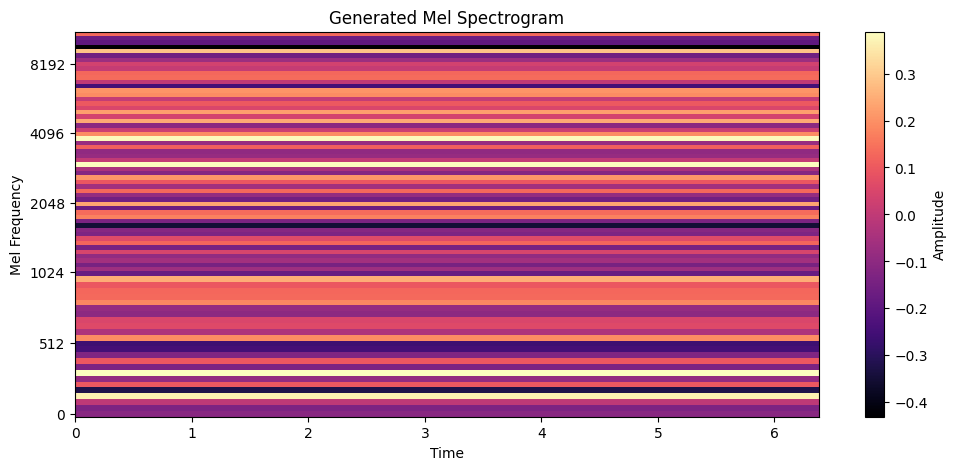

🔹 Expected Audio Duration: 0.93 seconds
✅ Fixed Audio Saved at: ./fixed_generated_audio.wav


In [ ]:
model_path = "tacotron_nlp_tts.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(model_path, map_location=device)


model = SimpleTacotron2(vocab_size=50, embedding_dim=256, encoder_dim=256, decoder_dim=256, mel_dim=80).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

phoneme_sequence = [user_phonemes]

# Convert phoneme sequence to IDs
phoneme_to_id = {p: i for i, p in enumerate(set(phoneme_sequence))}
phoneme_ids = [phoneme_to_id[p] for p in phoneme_sequence]

# Convert phoneme sequence to tensor
phoneme_tensor = torch.tensor([phoneme_ids], dtype=torch.long).to(device)

with torch.no_grad():
    mel_outputs = []
    mel_input = torch.zeros(1, 1, 80).to(device)
    max_mel_length = len(phoneme_ids) * 10
    stop_threshold = 0.5

    for i in range(max_mel_length):
        mel_output = model(phoneme_tensor)

        next_frame = mel_output[:, -1:, :]
        mel_outputs.append(next_frame)
        mel_input = torch.cat([mel_input, next_frame], dim=1)

        # If the model predicts a stop token that exceeds the threshold, break the loop
        # if stop_token is not None and stop_token[:, -1].item() > stop_threshold:
        #     print(f"Stopping generation at frame {i+1} based on stop token threshold.")
        #     break


    mel_spectrogram = torch.cat(mel_outputs, dim=1)


# Convert to NumPy
mel_spectrogram_np = mel_spectrogram.squeeze(0).cpu().numpy().astype(np.float32)

# Reverse normalization (if needed)
mel_spectrogram_np = (mel_spectrogram_np * 4)

# Save mel spectrogram
np.save("./mel_spectrogram.npy", mel_spectrogram_np)

# Plot mel spectrogram
plt.figure(figsize=(12, 5))
librosa.display.specshow(mel_spectrogram_np.T, sr=22050, hop_length=256, cmap="magma", x_axis="time", y_axis="mel")
plt.colorbar(label="Amplitude")
plt.title("Generated Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.savefig("generated_mel_spectrogram.png")
plt.show()


# Griffin-Lim

## Creating audio using Mel Spectrogam

In [ ]:
sr = 22050
n_fft = 1024
hop_length = 256
win_length = n_fft
mel_frames = mel_spectrogram_np.shape[1]
expected_duration = (mel_frames * hop_length) / sr
print(f"Expected Audio Duration: {expected_duration:.2f} seconds")
mel_to_linear = librosa.feature.inverse.mel_to_stft(mel_spectrogram_np, sr=sr, n_fft=n_fft)
computed_hop_length = 256

waveform = librosa.griffinlim(mel_to_linear, n_iter=150, hop_length=computed_hop_length, win_length=1024)

# Normalize waveform
waveform = waveform / np.max(np.abs(waveform))
audio_output_path = "./fixed_generated_audio.wav"
write(audio_output_path, sr, (waveform * 32767).astype(np.int16))

print(f"Audio Saved at: {audio_output_path}")



In [ ]:
print(f"Mel Spectrogram Shape: {mel_spectrogram_np.shape}")


Mel Spectrogram Shape: (550, 80)
